In [20]:
from tqdm.notebook import tqdm
from shapely.geometry import shape, mapping, Point, Polygon
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' 

import numpy as np
#import geoio

import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.wkt import loads


DATA_PATH = os.path.join('..', '..', '..', 'data', 'Brazil')
ESTIMATED_PATH = os.path.join('..', '..',  '..','estimated', 'Brazil') 

In [21]:
df_HDI = pd.read_csv(os.path.join(DATA_PATH, 'VR_clusters.csv'), sep=";", quotechar='"', dtype={'Cod_setor': 'string'}, encoding="utf-8")
df_HDI= df_HDI[['Cod_setor', 'lat', 'long', 'TIPO', 'income']]
print(df_HDI.shape)  # (880, 8)
print(df_HDI.columns)

df_DHS = pd.read_csv(os.path.join(ESTIMATED_PATH, 'VR_estimated_2010_2015_2020.csv'), sep=",", quotechar='"', dtype={'Cod_setor': 'string'}, encoding="utf-8")
df_DHS = df_DHS[['Cod_setor', 'long', 'lat', 'TIPO', 'Wealth_index_2010', 'Wealth_index_2015', 'Wealth_index_2020']]
print(df_DHS.shape) #(878, 5)
print(df_DHS.columns)


(880, 5)
Index(['Cod_setor', 'lat', 'long', 'TIPO', 'income'], dtype='object')
(880, 7)
Index(['Cod_setor', 'long', 'lat', 'TIPO', 'Wealth_index_2010',
       'Wealth_index_2015', 'Wealth_index_2020'],
      dtype='object')


In [22]:
df_DHS.head()

,Cod_setor,long,lat,TIPO,Wealth_index_2010,Wealth_index_2015,Wealth_index_2020
0,410310705000016,-49.091863,-25.248501,RURAL,-0.475248,-0.400104,-0.351413
1,410310705000019,-49.138532,-25.243704,RURAL,-0.109491,0.014330,0.107419
2,410310705000014,-48.986985,-25.232455,RURAL,-0.569952,-0.482709,-0.466943
3,411125805000034,-49.419701,-25.231852,RURAL,-0.532822,-0.395224,-0.384014
4,411125805000033,-49.356258,-25.230335,URBANO,0.747360,0.804022,0.788207


In [23]:
geo_HDI = pd.read_csv(os.path.join(DATA_PATH, 'setores_censitarios_vale_ribeira.csv'), sep=";", quotechar='"', dtype = {'CD_GEOCODI': 'string'}, encoding="utf-8")
print(geo_HDI.shape) #(954, 14)
#print(geo_HDI.columns)

temp = pd.merge(geo_HDI[['CD_GEOCODI', 'TIPO','NM_MESO', 'WKT']], df_HDI[['Cod_setor', 'lat', 'long', 'income']], \
     how='right', left_on='CD_GEOCODI', right_on='Cod_setor')

geo_HDI = gpd.GeoDataFrame(temp, crs= 'epsg:3857', geometry=[loads(pgon) for pgon in temp['WKT']])
geo_HDI = geo_HDI.to_crs(3857)  #coordinates in plain degrees

#3502705-05000001 cod_setor -> cod_municip
geo_HDI['Cod_municipio'] = geo_HDI['CD_GEOCODI'].astype(str).str[:7]

(954, 14)


In [24]:
geo_HDI.head()

,CD_GEOCODI,TIPO,NM_MESO,WKT,Cod_setor,lat,long,income,geometry,Cod_municipio
0,350270505000001,URBANO,ITAPETININGA,"MULTIPOLYGON (((-48.847133 -24.514689,-48.8475...",350270505000001,-48.848982,-24.513062,0.606203,"MULTIPOLYGON (((-48.84713 -24.51469, -48.84753...",3502705
1,350270505000002,URBANO,ITAPETININGA,"MULTIPOLYGON (((-48.845799 -24.51313,-48.84650...",350270505000002,-48.846967,-24.511579,0.671455,"MULTIPOLYGON (((-48.84580 -24.51313, -48.84650...",3502705
2,350270505000003,URBANO,ITAPETININGA,"MULTIPOLYGON (((-48.844894 -24.517396,-48.8450...",350270505000003,-48.845093,-24.514756,0.778504,"MULTIPOLYGON (((-48.84489 -24.51740, -48.84509...",3502705
3,350270505000004,URBANO,ITAPETININGA,MULTIPOLYGON (((-48.850383946118 -24.523331868...,350270505000004,-48.846954,-24.519240,0.808376,"MULTIPOLYGON (((-48.85038 -24.52333, -48.85048...",3502705
4,350270505000005,URBANO,ITAPETININGA,"MULTIPOLYGON (((-48.842276 -24.524945,-48.8424...",350270505000005,-48.841910,-24.522869,0.545806,"MULTIPOLYGON (((-48.84228 -24.52494, -48.84244...",3502705


In [25]:
#merge

temp = pd.merge(geo_HDI[['CD_GEOCODI', 'NM_MESO', 'WKT', 'income']], df_DHS[['Cod_setor', 'long', 'lat', 'TIPO','Wealth_index_2010','Wealth_index_2015','Wealth_index_2020']],  how='right', left_on='CD_GEOCODI', right_on='Cod_setor')


geo_DHS = gpd.GeoDataFrame(temp, crs= 'epsg:3857', geometry=[loads(pgon) for pgon in temp['WKT']])
geo_DHS = geo_DHS.to_crs(3857)  #coordinates in plain degrees

geo_DHS['Cod_municipio'] = geo_DHS['CD_GEOCODI'].astype(str).str[:8]

In [26]:
geo_HDI['Center_point'] = geo_HDI['geometry'].centroid.to_crs(epsg=3857)
geo_DHS['Center_point'] = geo_DHS['geometry'].centroid.to_crs(epsg=3857)


##### calculate abd difference between estimations 2010 - 2020

In [27]:
geo_DHS['abs_diff2020_2010'] = geo_DHS['Wealth_index_2020'] - geo_DHS['Wealth_index_2010']
geo_DHS['abs_diff2020_2010'] = geo_DHS['abs_diff2020_2010'].abs()

In [28]:
geo_DHS.head()

,CD_GEOCODI,NM_MESO,WKT,income,Cod_setor,long,lat,TIPO,Wealth_index_2010,Wealth_index_2015,Wealth_index_2020,geometry,Cod_municipio,Center_point,abs_diff2020_2010
0,410310705000016,METROPOLITANA DE CURITIBA,MULTIPOLYGON (((-49.100367641107 -25.218536336...,0.565532,410310705000016,-49.091863,-25.248501,RURAL,-0.475248,-0.400104,-0.351413,"MULTIPOLYGON (((-49.10037 -25.21854, -49.09776...",41031070,POINT (-49.09186 -25.24850),0.123835
1,410310705000019,METROPOLITANA DE CURITIBA,MULTIPOLYGON (((-49.1542493534809 -25.24190651...,0.549199,410310705000019,-49.138532,-25.243704,RURAL,-0.109491,0.014330,0.107419,"MULTIPOLYGON (((-49.15425 -25.24191, -49.15280...",41031070,POINT (-49.13853 -25.24370),0.216909
2,410310705000014,METROPOLITANA DE CURITIBA,MULTIPOLYGON (((-48.9530058714703 -25.19055962...,0.529791,410310705000014,-48.986985,-25.232455,RURAL,-0.569952,-0.482709,-0.466943,"MULTIPOLYGON (((-48.95301 -25.19056, -48.95154...",41031070,POINT (-48.98699 -25.23246),0.103008
3,411125805000034,METROPOLITANA DE CURITIBA,MULTIPOLYGON (((-49.4502781753574 -25.20029477...,0.506122,411125805000034,-49.419701,-25.231852,RURAL,-0.532822,-0.395224,-0.384014,"MULTIPOLYGON (((-49.45028 -25.20029, -49.45030...",41112580,POINT (-49.41970 -25.23185),0.148808
4,411125805000033,METROPOLITANA DE CURITIBA,MULTIPOLYGON (((-49.3565300086573 -25.22607369...,0.503397,411125805000033,-49.356258,-25.230335,URBANO,0.747360,0.804022,0.788207,"MULTIPOLYGON (((-49.35653 -25.22607, -49.35630...",41112580,POINT (-49.35626 -25.23033),0.040848


## Plot maps

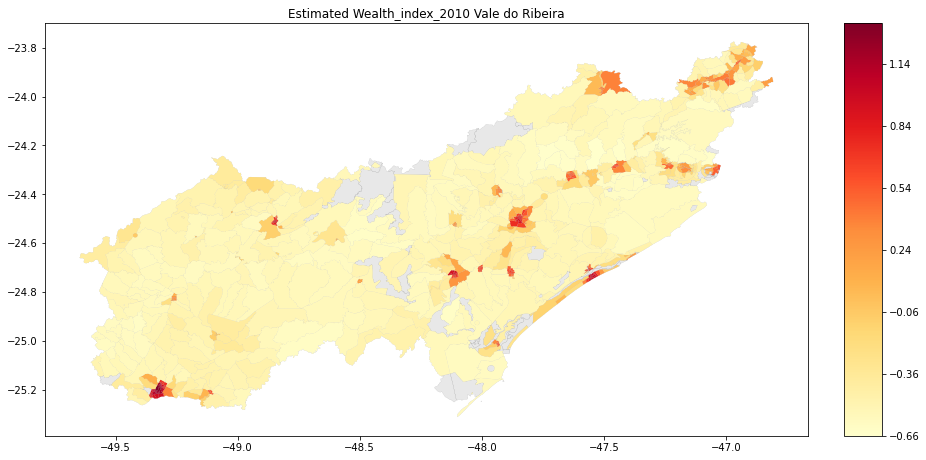

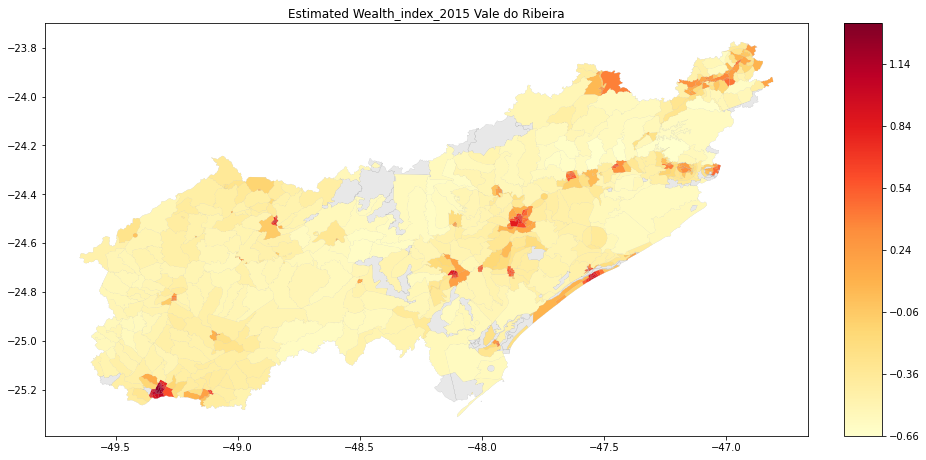

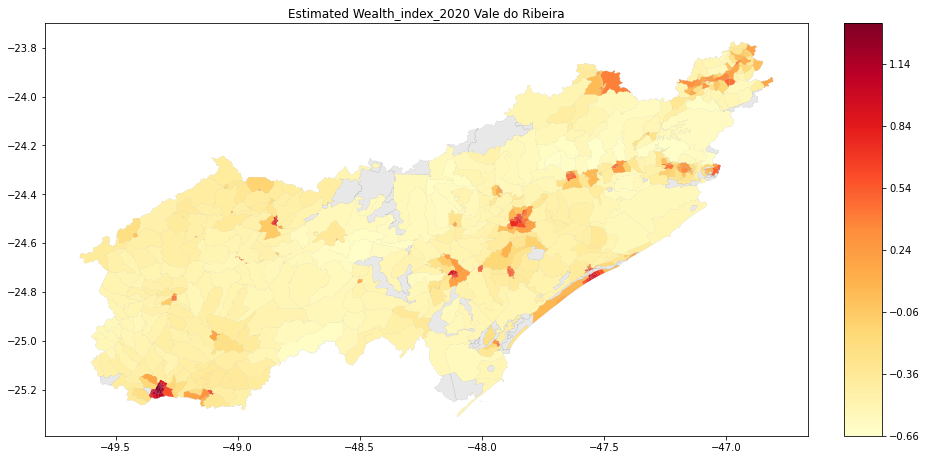

In [29]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

geo = gpd.read_file(os.path.join(DATA_PATH, 'shapefiles/vale_ribeira.dbf'))


#cmap = plt.cm.get_cmap('YlOrRd',5)    # DISCRETE colors YlOrRd
cmap = plt.cm.get_cmap('YlOrRd')    # conitnuous colors YlOrRd
#min2010	-0.6697483
#max2010	1.342727757
#min2015	-0.669005412
# max2015	1.421119928
# min2020	-0.684310895
# max2020	1.405987859

#for year_estimated in ['WI_norm2010','WI_norm2015','WI_norm2020']:
for year_estimated in ['Wealth_index_2010','Wealth_index_2015','Wealth_index_2020']: 
    fig, axs = plt.subplots(1, 1, figsize=(15,10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    def plot_colorbar(axes):        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.66, vmax=1.34))
        sm._A = []
        divider = make_axes_locatable(axes=axes)
        cax = divider.append_axes("right", size="5%", pad=0.5)
        cbar = fig.colorbar(sm, cax=cax,  ticks=np.arange(-0.66, 1.34, 0.3))
        #cbar.ax.set_title('Income score')
    
    axs.set_title(f'Estimated {year_estimated} Vale do Ribeira') 
    missing_kwds = dict(color='gray',alpha=0.1, label='No imagery data')
    geo.plot(color= 'lightgray',alpha=0.5, edgecolor='black', ax=axs, linewidth=0.1) #contourn
    geo_DHS.plot(column=year_estimated, k= 5,cmap=cmap,missing_kwds=missing_kwds, ax=axs)
    axs.axes.get_xaxis().set_visible(True)
    axs.axes.get_yaxis().set_visible(True)
    ####axs.set_aspect('equal')
    
    plot_colorbar(axs)

    # fig.patch.set_facecolor('white')
    #plt.rcParams['axes.facecolor'] = 'black'


    #this works fine to get transparente facecolor
    for item in [fig, axs]:
        item.patch.set_visible(False)

    plt.savefig(fname=os.path.join(f'figs/BR/fig5a_{year_estimated}.png'), format='png',dpi=300, facecolor='w', edgecolor='w' , transparent=True)
    plt.show() 



#### plot diff

In [30]:
geo_DHS['abs_diff2020_2010'].describe()

count    880.000000
mean       0.070086
std        0.066696
min        0.000079
25%        0.023744
50%        0.054272
75%        0.096286
max        0.544227
Name: abs_diff2020_2010, dtype: float64

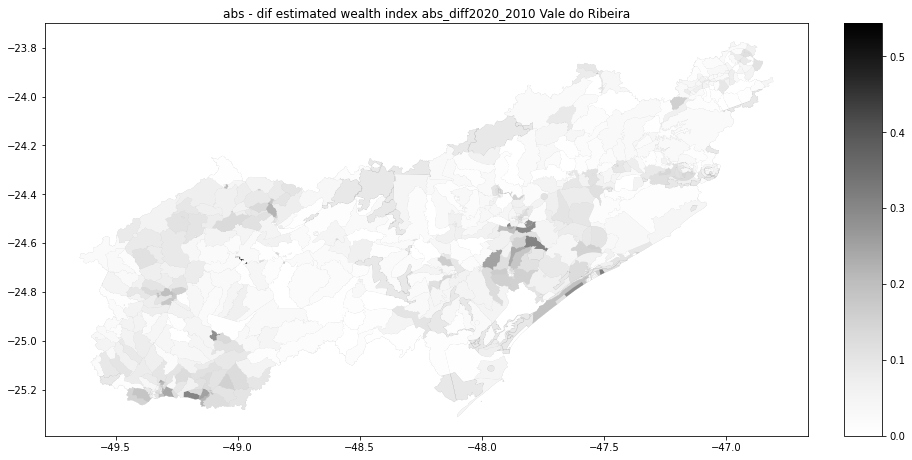

In [31]:
# count    880.000000
# mean       0.070086
# std        0.066696
# min        0.000079
# max        0.544227
#Name: abs_diff2020_2010

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

geo = gpd.read_file(os.path.join(DATA_PATH, 'shapefiles/vale_ribeira.dbf'))

 
cmap = plt.cm.get_cmap('Greys')    # conitnuous colors YlOrRd - change to black white
 
for year_estimated in ['abs_diff2020_2010']: 
    fig, axs = plt.subplots(1, 1, figsize=(15,10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    def plot_colorbar(axes):        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=0.544))
        sm._A = []
        divider = make_axes_locatable(axes=axes)
        cax = divider.append_axes("right", size="5%", pad=0.5)
        cbar = fig.colorbar(sm, cax=cax,  ticks=np.arange(0, 0.544, 0.1)) 
        # cbar = fig.colorbar(sm, cax=cax) 
    
    axs.set_title(f'abs - dif estimated wealth index {year_estimated} Vale do Ribeira') 
    missing_kwds = dict(color='gray',alpha=0.1, label='No imagery data')
    geo.plot(color= 'lightgray',alpha=0.5, edgecolor='black', ax=axs, linewidth=0.1) #contourn
    geo_DHS.plot(column=year_estimated, k= 5,cmap=cmap,missing_kwds=missing_kwds, ax=axs)
    axs.axes.get_xaxis().set_visible(True)
    axs.axes.get_yaxis().set_visible(True)
    ####axs.set_aspect('equal')
    
    plot_colorbar(axs)
 
    #this works fine to get transparente facecolor
    for item in [fig, axs]:
        item.patch.set_visible(False)

    plt.savefig(fname=os.path.join(f'figs/BR/fig5b.png'), format='png',dpi=300, facecolor='w', edgecolor='w' , transparent=True)
    plt.show() 


### plots with urban spot

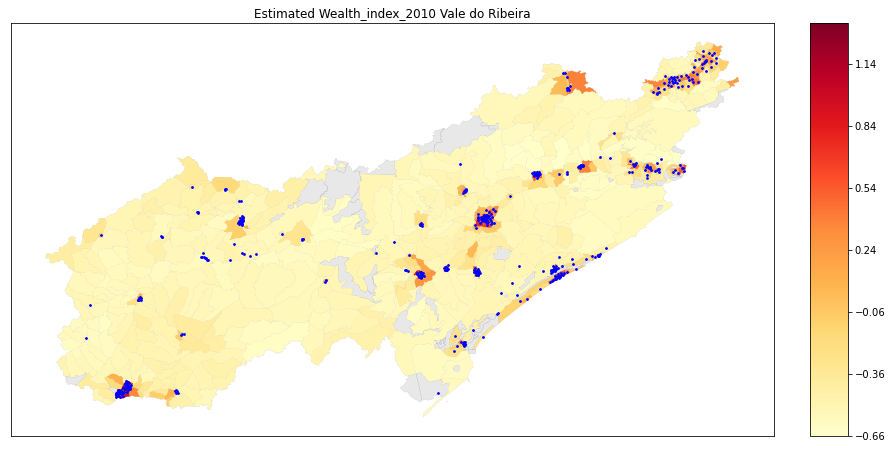

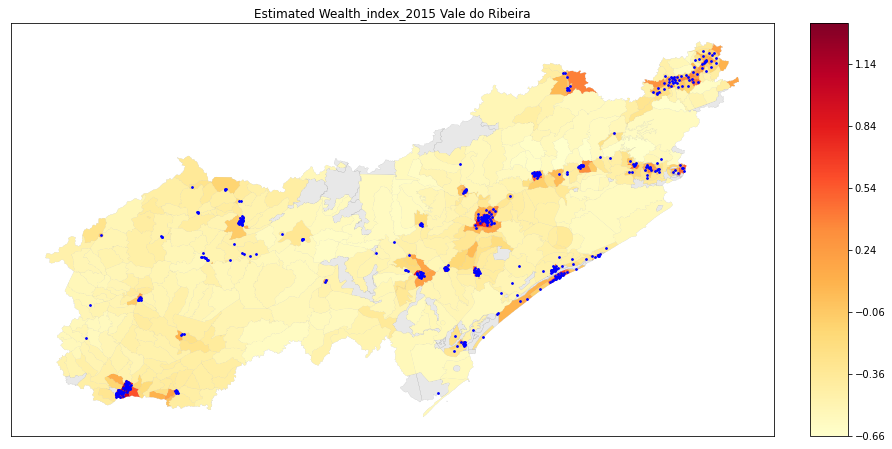

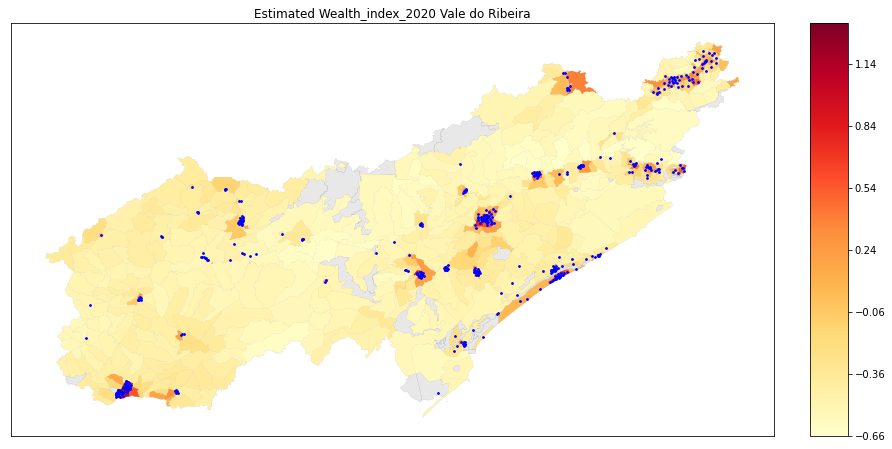

In [32]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

geo = gpd.read_file(os.path.join(DATA_PATH, 'shapefiles/vale_ribeira.dbf'))


#cmap = plt.cm.get_cmap('YlOrRd',5)    # DISCRETE colors YlOrRd
cmap = plt.cm.get_cmap('YlOrRd')    # conitnuous colors YlOrRd

# for year_estimated in ['WI_norm2010','WI_norm2015','WI_norm2020']:

for year_estimated in ['Wealth_index_2010','Wealth_index_2015','Wealth_index_2020']: 
    fig, axs = plt.subplots(1, 1, figsize=(15,10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    def plot_colorbar(axes):        
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1.00001))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.66, vmax=1.34)) 
        divider = make_axes_locatable(axes=axes)
        cax = divider.append_axes("right", size="5%", pad=0.5)
        cbar = fig.colorbar(sm, cax=cax,  ticks=np.arange(-0.66, 1.34, 0.3))
        #cbar.ax.set_title('Income score')
    
    axs.set_title(f'Estimated {year_estimated} Vale do Ribeira') 
    missing_kwds = dict(color='gray',alpha=0.1, label='No imagery data')
    geo.plot(color= 'lightgray',alpha=0.5, edgecolor='black', ax=axs, linewidth=0.1) #contourn
    geo_DHS.plot(column=year_estimated, k= 5,cmap=cmap,missing_kwds=missing_kwds, ax=axs)

    # plot urban spots
    df_tipo1= geo_DHS[geo_DHS['TIPO'] == 'URBANO']
    df_tipo1['Center_point'].plot(ax=axs, facecolor='blue', alpha=1.0, linewidth=1, markersize=3) #URBANO


    axs.axes.get_xaxis().set_visible(False)
    axs.axes.get_yaxis().set_visible(False)
    ###axs.set_aspect('equal')
    plot_colorbar(axs)

    # fig.patch.set_facecolor('white')
    #plt.rcParams['axes.facecolor'] = 'black'

    #this works fine to get transparente facecolor
    for item in [fig, axs]:
        item.patch.set_visible(False)
        
    plt.savefig(fname=os.path.join(f'figs/BR/fig5c_{year_estimated}_urban_spot.png'), dpi=300, facecolor='w', edgecolor='w', transparent=True)        
    plt.show() 
